In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import qutip
import scqubits
from scipy.optimize import minimize
from scipy.integrate import quad

In [65]:
# Parameters
anharmonicity = -0.3  # GHz
omega_d = 5.0         # Driving frequency in GHz
N = 8                 # Number of levels in the transmon
gamma = 0.05          # Dissipation rate
T = 1e5               # Pulse duration

# Operators
a = qutip.destroy(N)
# H0 = omega_d * (a.dag() * a + 0.5 * qeye(N)) + anharmonicity * a.dag()**2 * a**2

In [73]:
def drag_pulse(t, args):
    """
    DRAG pulse shape: Gaussian pulse with derivative
    """
    sigma = args['sigma']
    A = args['A']
    delta = args['delta']
    return A * np.exp(-((t - Т/2) ** 2) / (2 * sigma ** 2)) * (1 + 1j * delta * (t - Т/2) / (sigma ** 2))
    
#     return A * np.heaviside(t, 0) * np.heaviside(T-t, 0) * np.exp(-((t - T/2) ** 2) / (2 * sigma ** 2)) / (np.cos(np.arctan(delta * (t - T/2) / sigma ** 2))) * np.heaviside(t, 0) * np.heaviside(T-t, 0)
    
def drag_delta(t, args):
    """
    DRAG detuning shape: Lorentzian pulse with additive constant
    """
#     sigma = args['sigma']
#     A = args['A']
#     delta = args['delta']
#     d = args['d']
#     return A * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * (1 + 1j * delta * (t - t0) / (sigma ** 2))
    return d + np.heaviside(t, 0) * np.heaviside(T-t, 0) * (delta / sigma ** 2) / (1 + (delta * (t - T/2) / sigma ** 2) ** 2)

def sinusoidal_pulse(t, args):
    """
    Sinusoidal pulse shape: First half-period of a sine wave
    """
    A = args['A']
    T = args['T']
    d = args['d']
    return A * np.sin(np.pi * t / T) * np.heaviside(t, 0) * np.heaviside(T-t, 0)

def sine_delta(t, args):
    """
    Sine detuning shape: Constant
    """
    return args['d']


def hamiltonian_drive(pulse_func, delta_func, args):
    """
    Construct the time-dependent Hamiltonian for the given pulse shape
    """
    transmon = scqubits.Transmon(
    EJ=13.30993317,
    EC=0.26147263,
    ng=0,
    ncut=31,
    truncated_dim=8)    
    
    H0 = np.insert(np.diff(np.diag(transmon.hamiltonian(True))) - omega_d, 0, [0])
    H0 = np.diag(H0)
    # H0 += np.diag(np.ones(8) * args["d"])

    H1 = transmon.n_operator(True)
    
    H2 = np.diag(np.ones(8))
    H2[0,0] = 0
    
    H = [qutip.Qobj(H0), [qutip.Qobj(H1), pulse_func], [qutip.Qobj(H2), delta_func]]
    return H


def run_simulation(
    pulse_func, delta_func, 
    tlist,
    d_min, d_max, d_num,
    A_min, A_max, A_num
):
    """
    Run the time evolution simulation for the given pulse function and parameters
    """
    
    options = {}
    options['nsteps'] = 5000
    psi0 = qutip.basis(N, 0) * qutip.basis(N, 0).dag()  # initial state: ground state
    # result = mesolve(H, psi0, tlist, [], [basis(N, i) * basis(N, i).dag() for i in range(N)], args=pulse_args)
    d_range = np.linspace(d_min, d_max, d_num)
    A_range = np.linspace(A_min, A_max, A_num)
    tr_probs = []
    for n_d, d in enumerate(d_range):
        values = []
        for n_A, A in enumerate(A_range):
            pulse_args = {'sigma': T/10, 'A': A, 't0': T / 2, 'delta': -1 / (anharmonicity), 'd': d, 'T': T, 'N': N}
            H = hamiltonian_drive(pulse_func, delta_func, pulse_args)
            output = qutip.mesolve(
                H, psi0,
                args=pulse_args,
                tlist=tlist,
                options=options
            )
            values.append(output.states[-1])
        tr_probs.append(values)

    return tr_probs

In [74]:
def calculate_areas():
    pulse_args = {'sigma': T/10, 'A': 1, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N}
#     t = np.linspace(0,T,1000)
#     f = drag_pulse(t, pulse_args)
#     plt.plot(t, f)
#     plt.show()
    drag_area = quad(lambda t: drag_pulse(t, pulse_args), 0, pulse_args["T"])
    sine_area = quad(lambda t: sinusoidal_pulse(t, pulse_args), 0, pulse_args["T"])
    return drag_area, sine_area

drag, sine = calculate_areas()
drag_area, drag_area_err = drag
sine_area, sine_area_err = sine
A_drag_max = 10 * np.pi / drag_area
A_sine_max = 10 * np.pi / sine_area
A_drag_max,A_sine_max
# pulse_args = {'sigma': T/10, 'A': A_drag_max, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N}
# t = np.linspace(0,T,1000)
# f = drag_pulse(t, pulse_args)
# plt.plot(t, f)
# plt.show()
# g = drag_delta(t, pulse_args)
# plt.plot(t, g)
# plt.show()

(1.191560820773991, 0.49348022005446796)

In [69]:
# Simulation parameters
tlist = np.linspace(0, T, 50)  # Time grid
d_min, d_max, d_num = (-0.3, 0.3, 61)
A_min, A_num = (0, 60)

# Run simulations
result_drag = run_simulation(drag_pulse, drag_delta, tlist, d_min, d_max, d_num, A_min, A_drag_max, A_num)
result_sinusoidal = run_simulation(sinusoidal_pulse, sine_delta, tlist, d_min, d_max, d_num, A_min, A_sine_max, A_num)

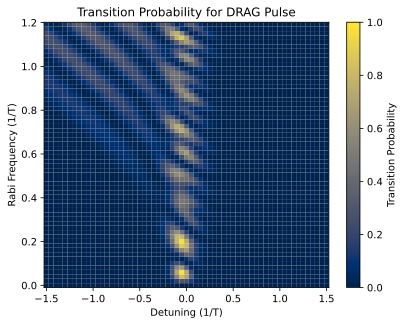

In [70]:
d_range = np.linspace(d_min, d_max, d_num)
A_drag_range = np.linspace(A_min, A_drag_max, A_num)
A_sine_range = np.linspace(A_min, A_sine_max, A_num)
tr_probs_drag = np.array([[np.abs(r[1,1]) for r in res] for res in result_drag])
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_drag_range, tr_probs_drag.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for DRAG Pulse')
plt.show()


(61, 60)


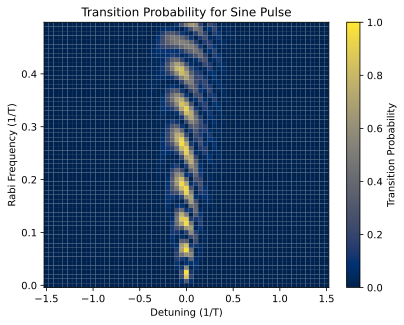

In [71]:
tr_probs_sin = np.array([[np.abs(r[1,1]) for r in res] for res in result_sinusoidal])
print(tr_probs_sin.shape)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_sine_range, tr_probs_sin.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for Sine Pulse')
plt.show()


In [75]:
# leakage = np.array([[[np.abs(r[d,d]) for d in range(2,8)] for r in res] for res in result_drag])

def leakage(result_optim):
    leakage_values = []
    for res in result_optim:
        leakage_line = []
        for r in res:
            leakage = 0
            for d in range(2, N):
                leakage += np.abs(r[d,d])
            leakage_line.append(leakage)
        leakage_values.append(leakage_line)
    return np.array(leakage_values)
    
leakage_drag = leakage(result_drag)
leakage_sine = leakage(result_sinusoidal)


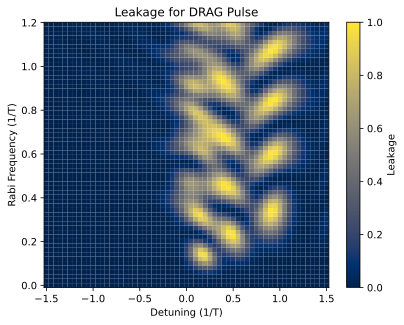

In [76]:
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_drag_range, leakage_drag.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Leakage')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Leakage for DRAG Pulse')
plt.show()

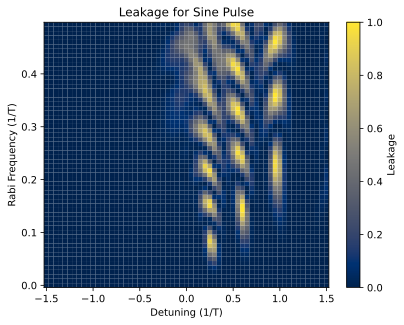

In [77]:
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_sine_range, leakage_sine.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Leakage')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Leakage for Sine Pulse')
plt.show()

In [79]:
# Define the objective function to be optimized
def objective_function(params):
    transmon = scqubits.Transmon(EJ=params[0],
                                 EC=params[1],
                                 ng=0,
                                 ncut=31,
                                 truncated_dim=8)
    exc_energies = np.diff(transmon.eigenvals())
    anharm = np.diff(exc_energies)[0]
    return (exc_energies[0] - obj_energy)**2 + (anharm - obj_anharm)**2


In [80]:
initial_guess = [10, 0.2]
obj_energy, obj_anharm = 5, -0.3
bounds = [(0, 100), (0, 100)]
result = minimize(objective_function, initial_guess, bounds=bounds)
# Print the optimization result
print("Optimization Result:")
print("Success:", result.success)
print("Message:", result.message)
print("Optimal Parameters:", result.x)
print("Objective Function Value at Optimum:", result.fun)

Optimization Result:
Success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimal Parameters: [13.30993317  0.26147263]
Objective Function Value at Optimum: 1.6115996210807837e-13


In [86]:
transmon = scqubits.Transmon(
    EJ=13.30993317,
    EC=0.26147263,
    ng=0,
    ncut=31,
    truncated_dim=8)    
exc_energies = np.diff(transmon.eigenvals())
anharm = np.diff(exc_energies)[0]
print(transmon.eigenvals())
print(exc_energies)
print(transmon.n_operator(True))
ham = np.diff(np.diag(transmon.hamiltonian(True))) + np.ones(7) * -5
ham = np.diag(np.insert(ham, 0, [0]))
print(ham)

[-10.73880615  -5.73880606  -1.03880558   3.32620235   7.25649019
  10.95066292]
[5.00000009 4.70000048 4.36500793 3.93028784 3.69417273]
[[ 1.26518893e-16 -1.09297838e+00 -6.30663116e-17 -3.92720558e-02
  -5.63888991e-17  3.18644837e-03  1.42441660e-17 -4.08977152e-04]
 [-1.09297838e+00 -2.87445196e-17  1.49791648e+00 -1.10448424e-16
  -8.59906806e-02  6.88232794e-17  1.14394581e-02  2.95500546e-17]
 [-8.03898567e-17  1.49791648e+00  2.53095638e-16  1.76526794e+00
  -1.71188590e-16 -1.50249701e-01  5.75064099e-18  1.92917659e-02]
 [-3.92720558e-02 -1.10723703e-16  1.76526794e+00 -3.65450591e-17
  -1.93865672e+00  1.26228502e-16  2.77299773e-01  8.40492992e-17]
 [-5.65066896e-17 -8.59906806e-02 -5.95605533e-17 -1.93865672e+00
   3.30767615e-18  1.97672903e+00 -1.37375604e-16 -2.78896509e-01]
 [ 3.18644837e-03  6.84911896e-17 -1.50249701e-01  1.21078543e-16
   1.97672903e+00 -7.34010121e-16 -2.19795186e+00 -4.58109381e-16]
 [ 1.64604420e-17  1.14394581e-02 -2.25791708e-17  2.77299773e-0

In [ ]:
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

# Define transmon parameters
Ej = 13.30993317  # Josephson energy in GHz
Ec = 0.26147263   # Charging energy in GHz
ng = 0.0          # Offset charge
ncut = 31         # Charge basis truncation
trunc = 8         # Truncation of the transmon Hilbert space

# Create Transmon object
transmon = scq.Transmon(EJ=Ej, EC=Ec, ng=ng, ncut=ncut, truncated_dim=trunc)

# Calculate the eigenvalues (energy levels) and eigenvectors of the transmon Hamiltonian
evals, evecs = transmon.eigensys()

# Construct the Hamiltonian in the energy basis (diagonal matrix with eigenvalues)
H_energy_basis = np.diag(evals)

# Print the Hamiltonian in the energy basis
print("Hamiltonian in the energy basis (diagonal elements):")
for idx, energy in enumerate(np.diag(H_energy_basis)):
    print(f"Level {idx}: {energy:.4f} GHz")

# Verify if the diagonal elements are positive
are_positive = np.all(np.diag(H_energy_basis) > 0)
print(f"\nAll diagonal elements positive: {are_positive}")
print(f"\nAll diagonal elements positive: {np.diag(H_energy_basis)}")

# Plot the Hamiltonian diagonal elements
plt.plot(np.diag(H_energy_basis), 'o-')
plt.xlabel("State index")
plt.ylabel("Energy (GHz)")
plt.title("Hamiltonian in the Energy Basis (Diagonal Elements)")
plt.grid(True)
plt.show()